In [1]:
import random
import json

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.optim.lr_scheduler import StepLR
from snntorch import spikegen
from sklearn.metrics import f1_score

from smogoutils import get_all_data_adj, compute_spiking_node_representation as csnr
from smogomodels import SMOGOGCN,SMOGOVCDN
from smogotrain import pretrain, smogotrain, smogotest, smogotrain_v2,smogotest_v2, check_convergence

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)

if device == "cuda":
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    torch.set_default_device("cuda")
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    torch.set_default_device("cpu")

device:  cpu


/Users/gabriquaranta/repos/mla-prj-24-mla24-prj19-gu1/.env/lib/python3.9/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [3]:
data_folder = "BRCA"
view_list = [1, 2, 3]
num_view=3
num_class = 5

(
    data_tr_list,
    data_trte_list,
    trte_idx,
    labels_trte,
    labels_tr_tensor,
    onehot_labels_tr_tensor,
    adj_tr_list,
    adj_te_list,
    dim_list,
) = get_all_data_adj(
    data_folder,
    view_list,
    num_class,
)

/Users/gabriquaranta/repos/mla-prj-24-mla24-prj19-gu1/SMOGONET/smogoutils.py:120: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:623.)
  return sparse_tensortype(indices, values, x.size())


In [4]:
K = 3
num_steps = 100

enc_function = 'rate'
# enc_function = 'latency'

H_tr_v1 = csnr(data_tr_list[0], adj_tr_list[0], K, num_steps, enc_function).to(device)
H_tr_v2 = csnr(data_tr_list[1], adj_tr_list[1], K, num_steps, enc_function).to(device)
H_tr_v3 = csnr(data_tr_list[2], adj_tr_list[2], K, num_steps, enc_function).to(device)

H_trte_v1 = csnr(data_trte_list[0], adj_te_list[0], K, num_steps, enc_function).to(device)
H_trte_v2 = csnr(data_trte_list[1], adj_te_list[1], K, num_steps, enc_function).to(device)
H_trte_v3 = csnr(data_trte_list[2], adj_te_list[2], K, num_steps, enc_function).to(device)

H_te_v1=H_trte_v1
H_te_v2=H_trte_v2
H_te_v3=H_trte_v3

labels_tr=labels_tr_tensor.to(device)
labels_trte_tensor = torch.tensor(labels_trte).to(device)
labels_te=labels_trte_tensor[trte_idx['te']].to(device)

print(H_tr_v1.shape, H_tr_v2.shape, H_tr_v3.shape)
print(H_trte_v1.shape, H_trte_v2.shape, H_trte_v3.shape)
print(labels_tr.shape, labels_trte_tensor.shape, labels_te.shape)

torch.Size([100, 612, 1000]) torch.Size([100, 612, 1000]) torch.Size([100, 612, 503])
torch.Size([100, 875, 1000]) torch.Size([100, 875, 1000]) torch.Size([100, 875, 503])
torch.Size([612]) torch.Size([875]) torch.Size([263])


In [5]:
dim_list = [H_tr_v1.shape, H_tr_v2.shape, H_tr_v3.shape]

# RANDOM GENERATION

In [6]:
# betas= [0.4,0.5,0.7,0.9]
# hidden_sizes= [30,40,50,60,70]
# starting_lrs= [0.1,0.01,0.001]
# step_sizes= [10,15,20,25,30]
# gammas= [0.2,0.4,0.5,0.6,0.8]

In [7]:
betas = np.linspace(0.2, 0.99, 10)
hidden_sizes = [int(i) for i in np.linspace(30, 80, 10)]
starting_lrs = np.linspace(0.1, 0.001, 10)
step_sizes = [int(i) for i in np.linspace(10, 30, 10)]
gammas = np.linspace(0.2, 0.8, 10)

In [8]:
def random_individual():
    ind={}
    ind['sgcn1']=[
        random.choice(betas),
        random.choice(betas),
        random.choice(hidden_sizes),
        random.choice(starting_lrs),
        random.choice(step_sizes),
        random.choice(gammas),
    ]
    ind['sgcn2']=[
        random.choice(betas),
        random.choice(betas),
        random.choice(hidden_sizes),
        random.choice(starting_lrs),
        random.choice(step_sizes),
        random.choice(gammas),
    ]
    ind['sgcn3']=[
        random.choice(betas),
        random.choice(betas),
        random.choice(hidden_sizes),
        random.choice(starting_lrs),
        random.choice(step_sizes),
        random.choice(gammas),
    ]
    ind['vcdn']=[
        random.choice(betas),
        random.choice(betas),
        random.choice(hidden_sizes),
        random.choice(starting_lrs),
        random.choice(step_sizes),
        random.choice(gammas),
    ]

    return ind

In [9]:
def models_from_ind_dict(ind_dict):
    sgcn1 = SMOGOGCN(
        input_size=dim_list[0][2], hidden_size=50, output_size=num_class, beta1=ind_dict['sgcn1'][0], beta2=ind_dict['sgcn1'][1]
        ).to(device)
    sgcn2 = SMOGOGCN(
        input_size=dim_list[1][2], hidden_size=50, output_size=num_class, beta1=ind_dict['sgcn2'][0], beta2=ind_dict['sgcn2'][1]
        ).to(device)
    sgcn3 = SMOGOGCN(
        input_size=dim_list[2][2], hidden_size=50, output_size=num_class, beta1=ind_dict['sgcn3'][0], beta2=ind_dict['sgcn3'][1]
        ).to(device)
    vcdn = SMOGOVCDN(
        input_size=125, hidden_size=ind_dict['vcdn'][2], output_size=num_class, beta1=ind_dict['vcdn'][0], beta2=ind_dict['vcdn'][1]
        ).to(device)
    
    return [sgcn1, sgcn2, sgcn3, vcdn]

In [10]:
def optim_scheduler_from_ind_dict(ind_dict,models_list):
    optim1 = optim.Adam(models_list[0].parameters(), lr=ind_dict['sgcn1'][3])
    optim2 = optim.Adam(models_list[1].parameters(), lr=ind_dict['sgcn2'][3])
    optim3 = optim.Adam(models_list[2].parameters(), lr=ind_dict['sgcn3'][3])
    optim4 = optim.Adam(models_list[3].parameters(), lr=ind_dict['vcdn'][3])

    scheduler1 = StepLR(optim1, step_size=ind_dict['sgcn1'][4], gamma=ind_dict['sgcn1'][5])
    scheduler2 = StepLR(optim2, step_size=ind_dict['sgcn2'][4], gamma=ind_dict['sgcn2'][5])
    scheduler3 = StepLR(optim3, step_size=ind_dict['sgcn3'][4], gamma=ind_dict['sgcn3'][5])
    scheduler4 = StepLR(optim4, step_size=ind_dict['vcdn'][4], gamma=ind_dict['vcdn'][5])

    return [
        optim1,optim2,optim3,optim4],[scheduler1,scheduler2,scheduler3,scheduler4
    ]


# RANDOM TRAINING TESTING

In [11]:

# random_dict=random_individual()
# models= models_from_ind_dict(random_dict)
# optims, schedulers= optim_scheduler_from_ind_dict(random_dict,models)

# # pretrain
# epochs_pretrain=60
# l1=pretrain(models[0], H_tr_v1, labels_tr, epochs_pretrain, random_dict['sgcn1'][1])
# l2=pretrain(models[1], H_tr_v2, labels_tr, epochs_pretrain, random_dict['sgcn2'][1])
# l3=pretrain(models[2], H_tr_v3, labels_tr, epochs_pretrain, random_dict['sgcn3'][1])

# # train
# num_epochs = 500
# H_trs = [H_tr_v1, H_tr_v2, H_tr_v3]

# losses = smogotrain(
#     models,
#     H_trs,
#     labels_tr,
#     opt_list=optims,
#     sched_list=schedulers,
#     num_epochs=num_epochs,
# )

# # testing
# idx_te = trte_idx['te']
# H_te_list = [H_te_v1, H_te_v2, H_te_v3]

# a = smogotest(models, H_te_list, labels_trte_tensor, labels_te, idx_te)


# print(json.dumps(random_dict, indent=4))

# FITNESS

In [12]:
def fitness(ind_dict,epoch_pre=100,epoch_tr=500,printing=False,saving=False):
    models= models_from_ind_dict(ind_dict)
    optims, schedulers= optim_scheduler_from_ind_dict(ind_dict,models)

    idx_te = trte_idx['te']
    H_trs = [H_tr_v1, H_tr_v2, H_tr_v3]
    H_te_list = [H_te_v1, H_te_v2, H_te_v3]

    if printing: print("\npretraining")
    l1=pretrain(models[0], H_tr_v1, labels_tr, epoch_pre, ind_dict['sgcn1'][1],printing=printing)
    l2=pretrain(models[1], H_tr_v2, labels_tr, epoch_pre, ind_dict['sgcn2'][1],printing=printing)
    l3=pretrain(models[2], H_tr_v3, labels_tr, epoch_pre, ind_dict['sgcn3'][1],printing=printing)

    if printing: print("\ntraining")
    losses=smogotrain_v2(models,H_trs,labels_tr,opt_list=optims,sched_list=schedulers,num_epochs=epoch_tr,printing=printing,l2_lambda=0.0)

    if printing: print("\ntesting")
    a = smogotest_v2(models, H_te_list, labels_trte_tensor, labels_te, idx_te,printing=printing)

    if saving:
        torch.save(models[0].state_dict(), f"models/ea_sgcn1.pth")
        torch.save(models[1].state_dict(), f"models/ea_sgcn2.pth")
        torch.save(models[2].state_dict(), f"models/ea_sgcn3.pth")
        torch.save(models[3].state_dict(), f"models/ea_svcdn.pth")

    return a   
    

In [13]:
# pop_size=3
# pop=[random_individual() for i in range(pop_size)]

# print([fitness(p) for p in pop])
# # 20 mins cpu

# MUTATION

In [14]:
def mutate(ind_dict_original):
    """
    possible mutations:
    - sgcns x3: beta, lr pre, lr tr, step_size, gamma
    - vcdn: beta1, beta2, hidden_size, lr, step_size, gamma
    """
    models_to_mutate = ['sgcn1','sgcn2','sgcn3','vcdn']
    model_to_mutate = random.choice(models_to_mutate)

    ind_dict=ind_dict_original.copy()

    if model_to_mutate=='vcdn':
        # mutate one of the fields
        field_to_mutate = random.choice([0,1,2,3,4,5])
        if field_to_mutate==0:
            ind_dict['vcdn'][0]=random.choice(betas)
        elif field_to_mutate==1:
            ind_dict['vcdn'][1]=random.choice(betas)
        elif field_to_mutate==2:
            ind_dict['vcdn'][2]=random.choice(hidden_sizes)
        elif field_to_mutate==3:
            ind_dict['vcdn'][3]=random.choice(starting_lrs)
        elif field_to_mutate==4:
            ind_dict['vcdn'][4]=random.choice(step_sizes)
        elif field_to_mutate==5:
            ind_dict['vcdn'][5]=random.choice(gammas)
    else:
        # mutate one of the fields
        field_to_mutate = random.choice([0,1,2,3,4])
        if field_to_mutate==0:
            ind_dict[model_to_mutate][0]=random.choice(betas)
        elif field_to_mutate==1:
            ind_dict[model_to_mutate][1]=random.choice(starting_lrs)
        elif field_to_mutate==2:
            ind_dict[model_to_mutate][2]=random.choice(starting_lrs)
        elif field_to_mutate==3:
            ind_dict[model_to_mutate][3]=random.choice(step_sizes)
        elif field_to_mutate==4:
            ind_dict[model_to_mutate][4]=random.choice(gammas)

    return ind_dict

# CROSSOVER

In [15]:
def xover(ind_dict_1,ind_dict_2):
    xover_point = random.choice([0,1,2])
    ind1=ind_dict_1.copy()
    ind2=ind_dict_2.copy()

    if xover_point==0:
        ind1['sgcn1']=ind_dict_2['sgcn1']
        ind2['sgcn1']=ind_dict_1['sgcn1']
    elif xover_point==1:
        ind1['sgcn1']=ind_dict_2['sgcn1']
        ind2['sgcn1']=ind_dict_1['sgcn1']
        ind1['sgcn2']=ind_dict_2['sgcn2']
        ind2['sgcn2']=ind_dict_1['sgcn2']
    elif xover_point==2:
        ind1['vcdn']=ind_dict_2['vcdn']
        ind2['vcdn']=ind_dict_1['vcdn']

    return ind1,ind2

# EA

In [16]:
# def check_convergence(values, window_size=5, min_gradient=0.001):
#     """
#     the min_gradient of 0.001 can be interpreted as follows:

#     - Meaning: The gradient represents the rate of change of the values over the
#     specified window. A gradient of 0.001 means that, on average, the value is
#     changing by 0.001 units per step within the window. 
    
#     - Direction: In the context of loss values in machine learning, a negative
#     gradient is typically expected (as loss should decrease). A gradient greater
#     than -0.001 (i.e., closer to zero or positive) suggests the loss is no
#     longer significantly decreasing.
#     """
#     if len(values) < window_size + 1:
#         return False
    
#     recent_values = values[-window_size:]
#     x = np.arange(window_size)
#     y = np.array(recent_values)
#     gradient, _ = np.polyfit(x, y, 1)
    
#     return abs(gradient) < min_gradient

In [17]:
POP_SIZE = 8
NUM_GENS = 10
NUM_PARENTS_BEST = 2
EPOCH_PRE = 2
EPOCH_TR = 5
MUTATION_RATE=0.2

# POP_SIZE=20
# NUM_GENS=100
# NUM_PARENTS_BEST=5
# EPOCH_PRE = 20
# EPOCH_TR = 80
# MUTATION_RATE=0.2

all_fitnesses=[]
best=None
best_fitness=0

pop = [random_individual() for i in range(POP_SIZE)]

for gen in range(NUM_GENS):
    print("\nGeneration: ", gen)

    # fitnesses=[fitness(p) for p in pop]
    fitnesses = [fitness(p, epoch_pre=EPOCH_PRE, epoch_tr=EPOCH_TR) for p in pop]  # for testing algo
    print(" Fitnesses: ", fitnesses)
    print(" Best fitness: ", max(fitnesses))
    print(" Average fitness: ", sum(fitnesses) / len(fitnesses))
    all_fitnesses.append(fitnesses)

    if gen == NUM_GENS - 1:
        break

    sortedp = sorted(zip(pop, fitnesses), key=lambda x: x[1], reverse=True)[
        :NUM_PARENTS_BEST
    ]

    if sortedp[0][1] > best_fitness:
        best_fitness = sortedp[0][1]
        best = sortedp[0][0]

    # # mutate
    # new_pop=[p[0] for p in sortedp] 
    # while len(new_pop)<POP_SIZE:
    #     new_pop.append(mutate(random.choice(sortedp)[0]))
    # pop=new_pop

    # # xover
    # new_pop = [p[0] for p in sortedp]  
    # while len(new_pop) < POP_SIZE:
    #     new_pop.extend(xover(random.choice(sortedp)[0], random.choice(sortedp)[0]))
    # pop = new_pop

    # xover + mutate
    new_pop = [p[0] for p in sortedp]  # keep some daddies
    while len(new_pop) < POP_SIZE:

        f1,f2=xover(random.choice(sortedp)[0], random.choice(sortedp)[0])

        if random.random()<MUTATION_RATE:
            f1=mutate(f1)
        if random.random()<MUTATION_RATE:
            f1=mutate(f2)

        new_pop.extend([f1,f2])
    pop = new_pop

    if check_convergence([np.mean(f) for f in all_fitnesses], window_size=3, min_gradient=0.01) and MUTATION_RATE<0.9:
        # TODO add counter for how many times this has happened to stop at some point
        MUTATION_RATE+=0.05
        print("Convergence detected. Increasing mutation rate to: ", MUTATION_RATE)


best_final = pop[fitnesses.index(max(fitnesses))]
print("\n\nBest individual final generation: ", best_final)
print("Best fitness final generation: ", max(fitnesses))
print("\nBest individual overall: ", best)
print("Best fitness overall: ", best_fitness)


Generation:  0
 Fitnesses:  [0.596958174904943, 0.44106463878326985, 0.5399239543726235, 0.5551330798479086, 0.5513307984790875, 0.5931558935361217, 0.5855513307984791, 0.634980988593156]
 Best fitness:  0.634980988593156
 Average fitness:  0.5622623574144486

Generation:  1
 Fitnesses:  [0.6425855513307984, 0.520912547528517, 0.5817490494296579, 0.520912547528517, 0.4752851711026616, 0.7300380228136882, 0.5133079847908746, 0.6159695817490495]
 Best fitness:  0.7300380228136882
 Average fitness:  0.5750950570342206

Generation:  2
 Fitnesses:  [0.5817490494296579, 0.6387832699619772, 0.6577946768060837, 0.7110266159695816, 0.6083650190114068, 0.634980988593156, 0.6083650190114068, 0.7072243346007605]
 Best fitness:  0.7110266159695816
 Average fitness:  0.6435361216730038

Generation:  3
 Fitnesses:  [0.7490494296577948, 0.5285171102661597, 0.5665399239543725, 0.6387832699619772, 0.6273764258555133, 0.5893536121673005, 0.570342205323194, 0.5475285171102663]
 Best fitness:  0.749049429

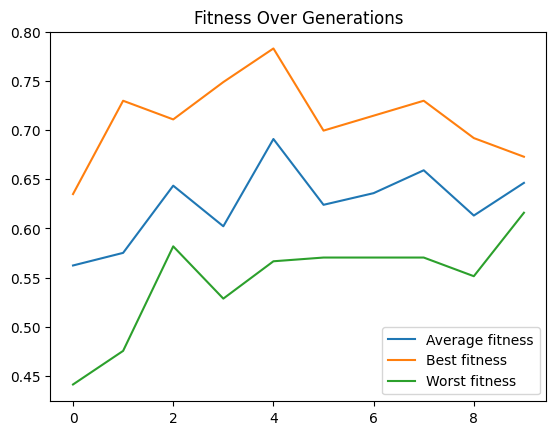

In [18]:
plt.figure()
plt.title("Fitness Over Generations")
plt.plot([sum(f) / len(f) for f in all_fitnesses], label="Average fitness")
plt.plot([max(f) for f in all_fitnesses], label="Best fitness")
plt.plot([min(f) for f in all_fitnesses], label="Worst fitness")
plt.legend()
plt.show()

In [19]:
saving = True
saving = False
fitness(best,epoch_pre=100,epoch_tr=500,printing=True,saving=saving)


pretraining
Epoch 20/100, Loss: 1.1413891315460205
Epoch 40/100, Loss: 1.0887337923049927
Epoch 60/100, Loss: 1.0724995136260986
Epoch 80/100, Loss: 1.0632704496383667
Epoch 100/100, Loss: 1.0566892623901367
Epoch 20/100, Loss: 1.268090844154358
Epoch 40/100, Loss: 1.1727365255355835
Epoch 60/100, Loss: 1.1423051357269287
Epoch 80/100, Loss: 1.1256099939346313
Epoch 100/100, Loss: 1.116377592086792
Epoch 20/100, Loss: 1.3378512859344482
Epoch 40/100, Loss: 1.2390469312667847
Epoch 60/100, Loss: 1.1898826360702515
Epoch 80/100, Loss: 1.1699451208114624
Epoch 100/100, Loss: 1.1587460041046143

training
Epoch 1/500, Loss: 1.6152793169021606
Epoch 11/500, Loss: 1.1428664922714233
Epoch 21/500, Loss: 1.0894544124603271
Epoch 31/500, Loss: 1.0692862272262573
Epoch 41/500, Loss: 1.053400993347168
Epoch 51/500, Loss: 1.0451055765151978
Epoch 61/500, Loss: 1.0400128364562988
Epoch 71/500, Loss: 1.036942481994629
Converged at epoch 76, Loss = 1.035842776298523

testing
Over 10 test runs:
- Accu

0.8479087452471481